In [1]:
%matplotlib inline
#reads cdf files in python
from spacepy import pycdf
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import make_discrete_vdf as mdv
import numpy as np
import matplotlib.pyplot as plt
from fancy_plot import fancy_plot
from multiprocessing import Pool
import time
from scipy.optimize import curve_fit
import multi_fc_functions as mff
from scipy.interpolate import RectBivariateSpline
import time
from scipy import optimize
import numpy as np
import scipy.linalg
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import read_fmt_obs as rfo

In [3]:
#Time you are interested in reconstructing
date = '2019/02/09 00:10:00'

In [4]:
reload(rfo)
#Read in Wind spectra and parameters and format them in a way that can be used by the reconstruction program
fcs,vdf_inpt = rfo.fmt_wind_spec(date)

(<matplotlib.figure.Figure at 0x105f8c6d0>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x126396710>,
         <matplotlib.axes._subplots.AxesSubplot object at 0x12a614250>]], dtype=object))

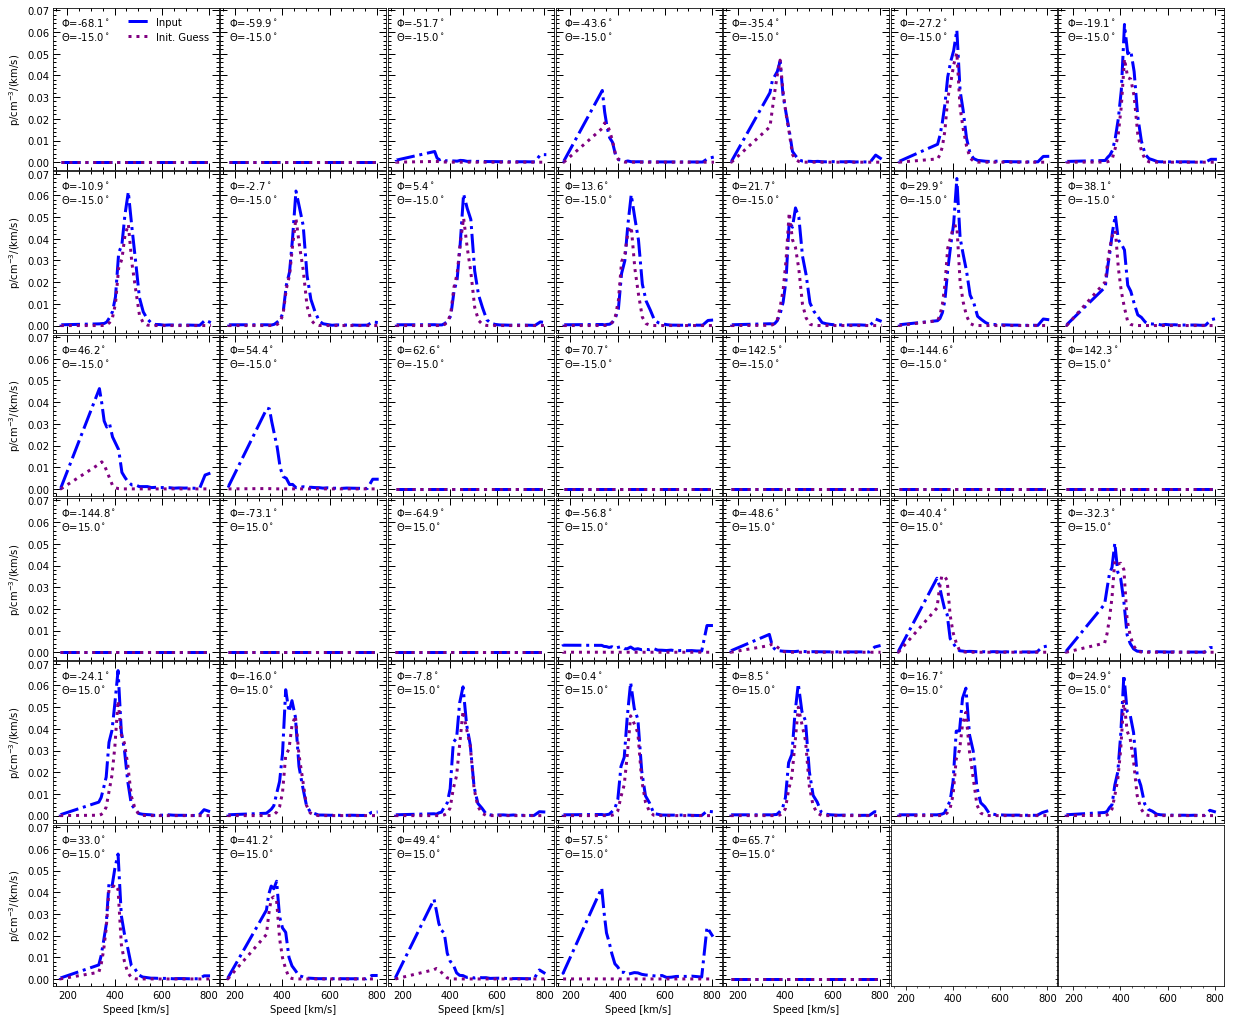

In [5]:
#Plot the Observations of all Wind FCs and the Velocity distribution if the bi-maxwellian solution 
#Derived by Wind for each FC
reload(mff)
mff.create_fc_grid_plot(fcs)

In [6]:
#Trying a guess based on a previous failed try at fitting_wind_observation
human_guess = [ -4.35047381e+02,  -1.35264270e+01,   7.15811005e+00,   2.51430881e+01,
                 2.70190565e+01,   2.06592978e-02,   2.81259051e+00,   2.16901722e+00,
                 3.84810371e+01,   1.06937488e+01,   4.40914378e+01,   4.85236340e+01,
                 6.79767052e-03,   1.60664033e+00,   1.78231253e+00,]                


In [7]:
#Previous observation was at a different time so adjust velocity solution
human_guess[:3] = vdf_inpt['u_gse']

In [8]:
#Get magnetic fields from Wind CDF file that is stored in the vdf dictionary
b_gse = vdf_inpt['b_gse']
#Set the size of the VDF solution
vel_clip = 200. #km/s

(<matplotlib.figure.Figure at 0x12ce6ec90>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12a48f710>,
         <matplotlib.axes._subplots.AxesSubplot object at 0x12deae1d0>]], dtype=object))

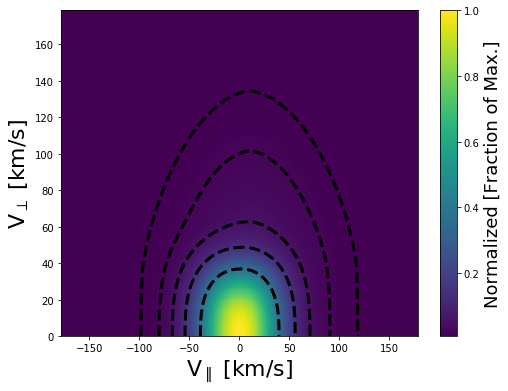

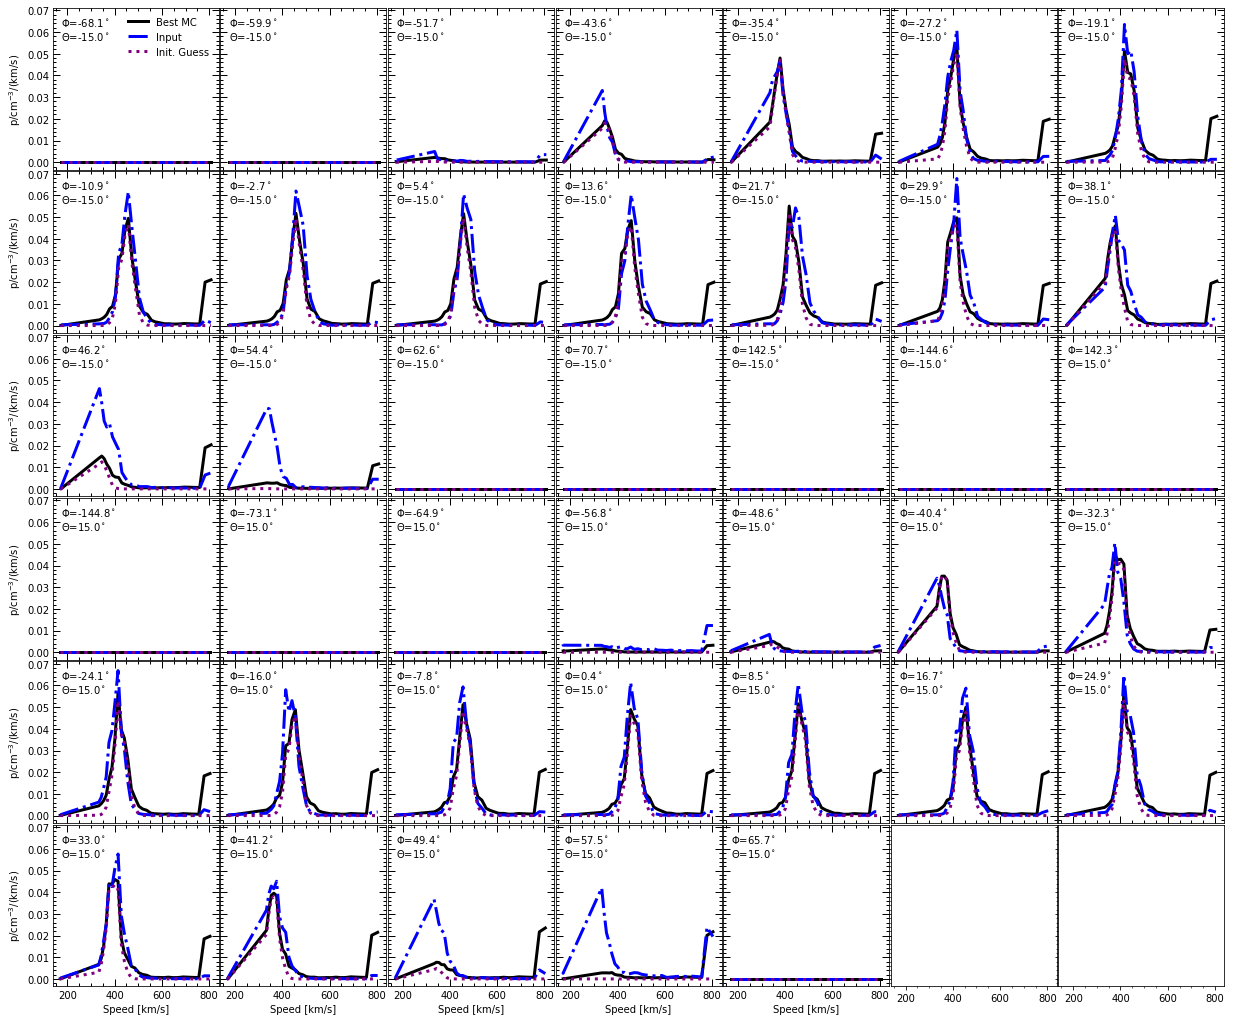

In [9]:
#Show what the initial guess assuming at generalized normal distribution
#looks like compared to the measurements and the bi-maxellian fit and Observations
dis_vdf_human = mdv.make_discrete_gennorm_vdf(human_guess,b_gse,pres=1.00,qres=1.00,clip=vel_clip,
                                                  add_ring=human_guess[8:])
#Plot what the velocity distribution looks like
mdv.plot_vdf(dis_vdf_human)
#measure the velocity distribution for each FC based on the input parameters
samp = 15.
for k,i in enumerate(fcs.keys()):
    i = 'fc_{0:1d}'.format(k)
    #updated using dynamic sampling 2018/10/12 J. Prchlik
    fcs[i]['dis_cur'] = mdv.arb_p_response(fcs[i]['x_meas'],dis_vdf_human,samp)

mff.create_fc_grid_plot(fcs)

In [10]:
#maximum tries
max_try = 2200*3 #about 12 hours

In [11]:
#Notice NM can converge better than Powell with complex solutions, so trying it now
x1 = time.time()
#Try to minimize the sum squared errors for all FC to fit the best fit
#True means include ring in final fit
nm_human = optimize.minimize(mff.gennorm_2d_reconstruct,human_guess, args=(fcs,dis_vdf_human,True),method='Nelder-Mead',
                            options={'xtol':1e-2,'ftol':1e-2,'disp':True,'maxiter':max_try,'maxfev':max_try})
x2 = time.time()

Optimization terminated successfully.
         Current function value: 0.009594
         Iterations: 3610
         Function evaluations: 4737


(<matplotlib.figure.Figure at 0x12b889d90>,
 <matplotlib.axes._subplots.AxesSubplot at 0x130808e90>)

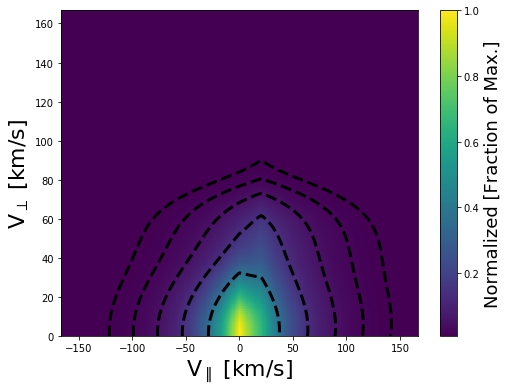

In [12]:
#Create Vper and Vpar velocity distribution and plot it
human_vdf =  mdv.make_discrete_gennorm_vdf(nm_human.x,b_gse,pres=1.00,qres=1.00,clip=vel_clip,
                                                  add_ring=nm_human.x[8:])
#Make the observations for the best fit solution
samp = 15.
for k,i in enumerate(fcs.keys()):
    i = 'fc_{0:1d}'.format(k)
    #updated using dynamic sampling 2018/10/12 J. Prchlik
    fcs[i]['dis_cur'] = mdv.arb_p_response(fcs[i]['x_meas'],human_vdf,samp)
    
#Plot the best fit 2D velocity distribution
mdv.plot_vdf(human_vdf)


(<matplotlib.figure.Figure at 0x105f8c7d0>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1307e7590>,
         <matplotlib.axes._subplots.AxesSubplot object at 0x131c4c7d0>]], dtype=object))

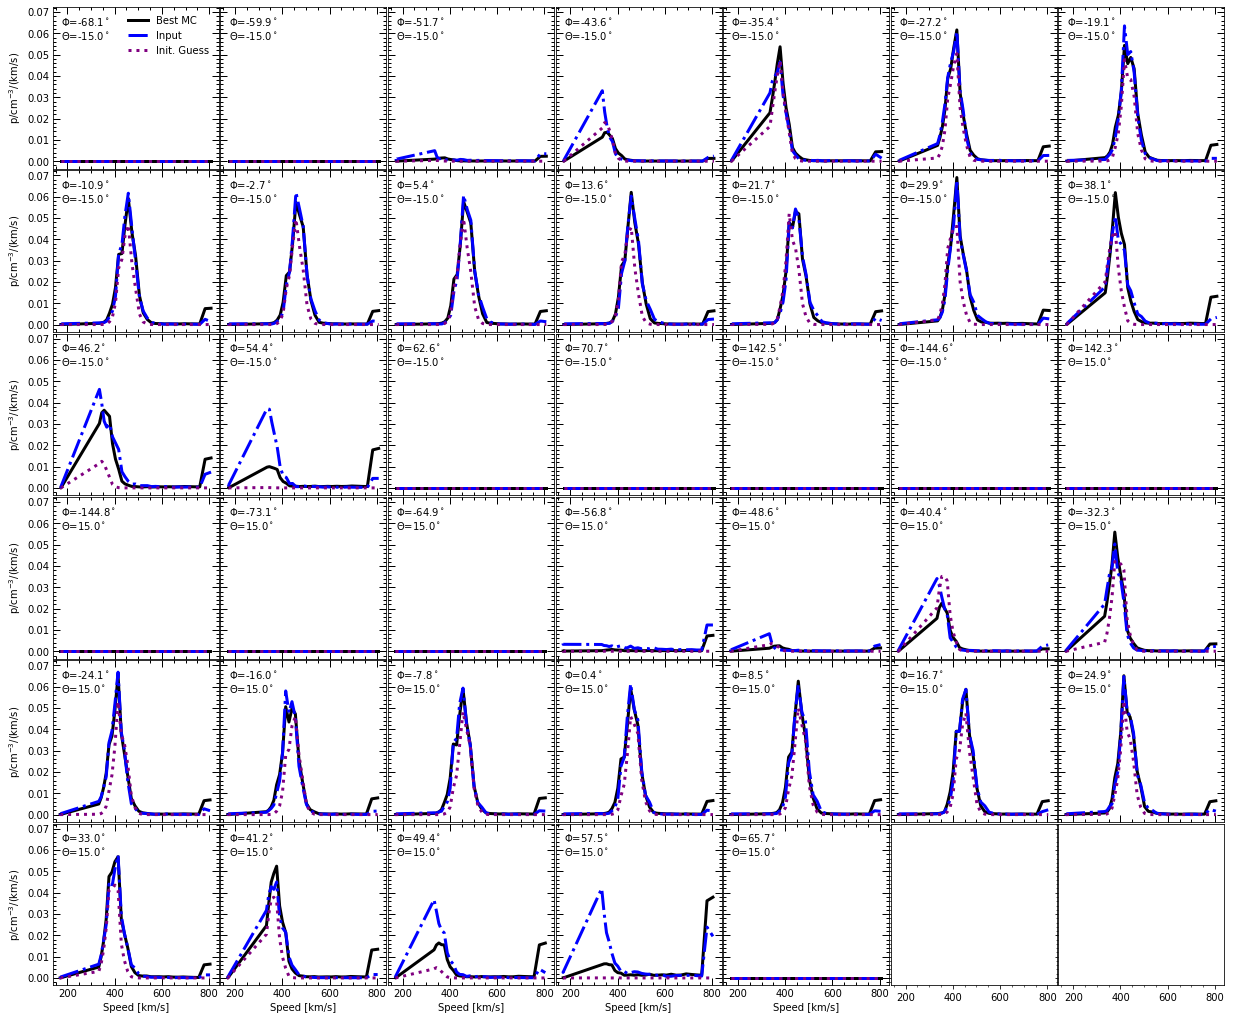

In [13]:
#Visually compare the best fit velocity solution (Best MC), the bi-maxwell (Init. Guess), and the observations (Input)
mff.create_fc_grid_plot(fcs)

In [14]:
#Total run time until convergence
print('Total Run Time {0:7.1f} min'.format((x2-x1)/60.))

Total Run Time   652.0 min


In [15]:
#The values of the final parameters S is the new parameter in the generalized normal (s=2 is a Guassian)
#[Vx,Vy,Vx,Wper,
# Wpar,Peak,Sper,Spar,
# Vper_ring,Vpar_ring,Wper_ring,Wpar_ring,
# Peak_ring,Sper_ring,Spar_ring]
print(nm_human.x)

[ -4.81553276e+02  -1.51891999e+01   1.44194167e+01   2.02555390e+01
   2.01025025e+01   1.75889476e-02   2.06569586e+00   1.15282426e+00
   2.90526996e+01   2.03196527e+01   2.78573459e+01   2.52803827e+01
   1.38017109e-02   4.05130097e+00   1.09343779e+00]


In [16]:
import dill
import pickle

In [17]:
#dill.dump_session('simplified_wind_spectral_fit.db',byref=True,main=False)
pickle_out = open("nm_spectral_fit_changed_input_effective_area.pickle","wb")
dill.dump(nm_human,pickle_out)
pickle_out.close()

In [22]:

#Comparing effective area from cdf to that in code to make sure they are consistent
parm_dir = 'test_obs/test_wind_spectra/'
spec_dir = 'test_obs/test_wind_spectra/'
parm_fmt = 'wi_h1_swe_{0:%Y%m%d}_v01.cdf'
spec_fmt = 'wi_sw-ion-dist_swe-faraday_{0:%Y%m%d}_v01.cdf'

#The observation time
obs_time = pd.to_datetime(date)

#full name of the derived parameters file
parm_fil = parm_dir+parm_fmt.format(obs_time)
#full name of the ion spectrum file
spec_fil = spec_dir+spec_fmt.format(obs_time)
                                    
                                    
                                    
#read in ion spectrum and parameter file
wind_spec = pycdf.CDF(spec_fil)
wind_parm = pycdf.CDF(parm_fil)
    
#Get effective area calculation from the FC spec cdf
cup_area = wind_spec['calibration_effArea'][...]*1e5
cup_angl = wind_spec['calibration_angle'][...]






In [23]:
#Get Theoretical effective area for give spacecraft
eff_area = mdv.return_space_craft_ef('wind')
eff_angl = np.arange(eff_area.size)/10.

In [24]:
print(max(eff_angl))

90.9


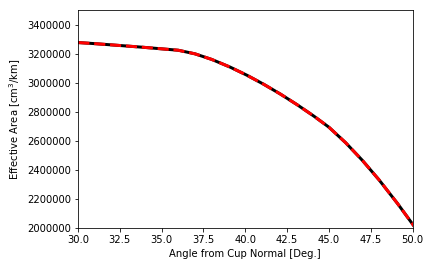

In [27]:
fig, ax = plt.subplots()

ax.plot(eff_angl,eff_area,color='black',linewidth=3,label='Th. Eff')
ax.plot(cup_angl,cup_area,color='red',linestyle='--',linewidth=3,label='CDF Eff')

ax.set_xlim([0,90])
ax.set_xlim([30,50])
ax.set_ylim([2e6,3.5e6])
ax.set_xlabel('Angle from Cup Normal [Deg.]')
ax.set_ylabel('Effective Area [cm$^3$/km]')

plt.show()